In [8]:
import re
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
path = 'competition_files//' # Путь до папки с файлами соревнования
feature_path = 'features//'

### Самый простой путь, считаем максимумы совпадающих слов в группе

In [114]:
doc_to_title = {}
with open(f'{path}docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [119]:
import pandas as pd
train_data = pd.read_csv(f'{path}train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

pattern = r"[^\w\d' ']"
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(re.sub(pattern, " ", str(title).lower()).strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        all_dist = np.asarray(all_dist)
        X_train.append(sorted(all_dist, reverse=True)[0:25])
X = np.array(X_train)
y = np.array(y_train)
groups_train = np.array(groups_train)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
np.hstack((X, y[:, None])).dump(f'{feature_path}basic_features')


### Считаем меру похожести заголовков через TFIDF

In [130]:
docs_titles = pd.read_table(f'{path}docs_titles.tsv')
train_groups = pd.read_csv(f'{path}train_groups.csv')
test_groups = pd.read_csv(f'{path}test_groups.csv')
data = pd.merge(train_groups, docs_titles, how='left', on='doc_id')[['group_id', 'title', 'target']]
test_data = pd.merge(test_groups, docs_titles, how='left', on='doc_id')[['group_id', 'title', 'pair_id']]
def transform_data(data):
    pattern = r"[^\w\d' ']"
    data['title'] = np.asarray([re.sub(pattern, " ", str(title).lower()) for title in data['title']])

In [135]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [136]:
data[data.group_id == 55]

,group_id,title,target
4815,55,Если вменяют оставление места дтп,0
4816,55,"Нарушение п.9.10, 10.1 - наказание ст. 12.15 ч...",0
4817,55,Das TatarstanКак посмотреть фото нарушения ПДД...,1
4818,55,НАРУШЕНИЕ ПРАВИЛ ОСТАНОВКИ И СТОЯНКИ,0
4819,55,МБОУ Сорская ООШ № 2 им. Толстихиной Ю.Н. - МБ...,0
4820,55,Подскажите где посмотреть штрафы с фото — DRIVE2,1
4821,55,гост количество полос на дороге,0
4822,55,Приложение «Штрафы ПДД» покажет фото ваших нар...,0
4823,55,Штрафы ГИБДД с фотографиями нарушений | Штрафы...,1
4824,55,sl | Добрый автоинструктор,0


In [23]:
transform_data(data)

In [51]:
transform_data(test_data)

In [108]:
def get_features(data):
    onehot_groupid = np.zeros((len(data), max(data['group_id'])))
    for i, group_id in enumerate(data['group_id']):
        onehot_groupid[i, group_id - 1] = 1
    max_features = 25
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = np.zeros((1, max_features))
    for _, group in data.groupby('group_id'):
        titles_tfidf = vectorizer.fit_transform(np.asarray(group['title'])).toarray()
        X = np.concatenate((X, titles_tfidf))
    return np.hstack((X[1:], np.asarray(data['group_id'])[:, None]))

transform_data(data)

scaler = StandardScaler()
X = get_features(data)
X = scaler.fit_transform(X)
y = np.asarray(data['target'])

In [96]:
transform_data(test_data)

In [97]:
X_test = get_features(test_data)
X_test = scaler.fit_transform(X_test)

In [127]:
m = 1000

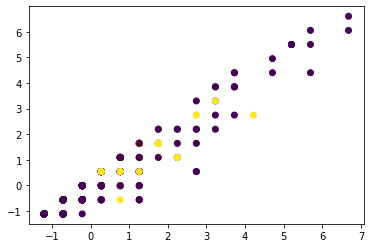

In [128]:
plt.scatter(X[:m, 0], X[:m, 1], c=y[:m])

In [120]:
gkf = GroupKFold(n_splits=5)
scores = []
for train, test, in gkf.split(X, y, groups=groups_train):
    clf = svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
    clf.fit(X[train], y[train])
    prediction = clf.predict(X[test])
    scores.append(f1_score(y[test], prediction))

In [121]:
scores

[0.5321100917431193,
 0.5309446254071661,
 0.7232390460343872,
 0.6223684210526316,
 0.7231800766283525]

In [46]:
scores

[0.5504300234558248,
 0.5516717325227963,
 0.7104984093319195,
 0.6555183946488294,
 0.7131782945736435]

In [82]:
X

array([[-0.28818908, -0.3087629 ,  1.56439866, ..., -0.34397381,
        -0.32733266, -0.33867474],
       [-0.28818908,  1.58931462,  1.14566273, ...,  2.03077767,
        -0.32733266,  1.85362691],
       [-0.28818908, -0.3087629 , -0.31576373, ..., -0.34397381,
         2.7099957 , -0.33867474],
       ...,
       [-0.28818908, -0.3087629 , -0.31576373, ..., -0.34397381,
        -0.32733266, -0.33867474],
       [-0.28818908, -0.3087629 , -0.31576373, ..., -0.34397381,
        -0.32733266,  5.31500637],
       [-0.28818908, -0.3087629 , -0.31576373, ..., -0.34397381,
        -0.32733266, -0.33867474]])

In [81]:
X_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.41621787, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.25375326, 0.52373085,
        0.        ],
       [0.        , 0.51759681, 0.42174167, ..., 0.20433839, 0.        ,
        0.37643776],
       [0.38826693, 0.        , 0.26603187, ..., 0.12889531, 0.        ,
        0.        ]])

In [99]:
clf.fit(X, y)

SVC(C=10, class_weight='balanced', gamma=0.001)

In [100]:
prediction = clf.predict(X_test)

In [101]:
prediction.shape

(16627,)

In [102]:
subm = pd.DataFrame({'pair_id': test_data['pair_id'], 'target': prediction})

In [103]:
subm.to_csv("submission.csv", index=False)

In [104]:
prediction.sum()

6643